# 5.6. Optimizing Cython code by writing less Python and more C

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
w, h = 400, 400  # Size of the screen in pixels.

In [4]:
def normalize(x):
    # This function normalizes a vector.
    x /= np.linalg.norm(x)
    return x

In [5]:
def intersect_sphere(O, D, S, R):
    # Return the distance from O to the intersection
    # of the ray (O, D) with the sphere (S, R), or
    # +inf if there is no intersection.
    # O and S are 3D points, D (direction) is a
    # normalized vector, R is a scalar.
    a = np.dot(D, D)
    OS = O - S
    b = 2 * np.dot(D, OS)
    c = np.dot(OS, OS) - R * R
    disc = b * b - 4 * a * c
    if disc > 0:
        distSqrt = np.sqrt(disc)
        q = (-b - distSqrt) / 2.0 if b < 0 \
            else (-b + distSqrt) / 2.0
        t0 = q / a
        t1 = c / q
        t0, t1 = min(t0, t1), max(t0, t1)
        if t1 >= 0:
            return t1 if t0 < 0 else t0
    return np.inf

In [6]:
def trace_ray(O, D):
    # Find first point of intersection with the scene.
    t = intersect_sphere(O, D, position, radius)
    # No intersection?
    if t == np.inf:
        return
    # Find the point of intersection on the object.
    M = O + D * t
    N = normalize(M - position)
    toL = normalize(L - M)
    toO = normalize(O - M)
    # Ambient light.
    col = ambient
    # Lambert shading (diffuse).
    col += diffuse * max(np.dot(N, toL), 0) * color
    # Blinn-Phong shading (specular).
    col += specular_c * color_light * \
        max(np.dot(N, normalize(toL + toO)), 0) \
        ** specular_k
    return col

In [7]:
def run():
    img = np.zeros((h, w, 3))
    # Loop through all pixels.
    for i, x in enumerate(np.linspace(-1, 1, w)):
        for j, y in enumerate(np.linspace(-1, 1, h)):
            # Position of the pixel.
            Q[0], Q[1] = x, y
            # Direction of the ray going through
            # the optical center.
            D = normalize(Q - O)
            # Launch the ray and get the color
            # of the pixel.
            col = trace_ray(O, D)
            if col is None:
                continue
            img[h - j - 1, i, :] = np.clip(col, 0, 1)
    return img

In [8]:
# Sphere properties.
position = np.array([0., 0., 1.])
radius = 1.
color = np.array([0., 0., 1.])
diffuse = 1.
specular_c = 1.
specular_k = 50

# Light position and color.
L = np.array([5., 5., -10.])
color_light = np.ones(3)
ambient = .05

# Camera.
O = np.array([0., 0., -1.])  # Position.
Q = np.array([0., 0., 0.])  # Pointing to.

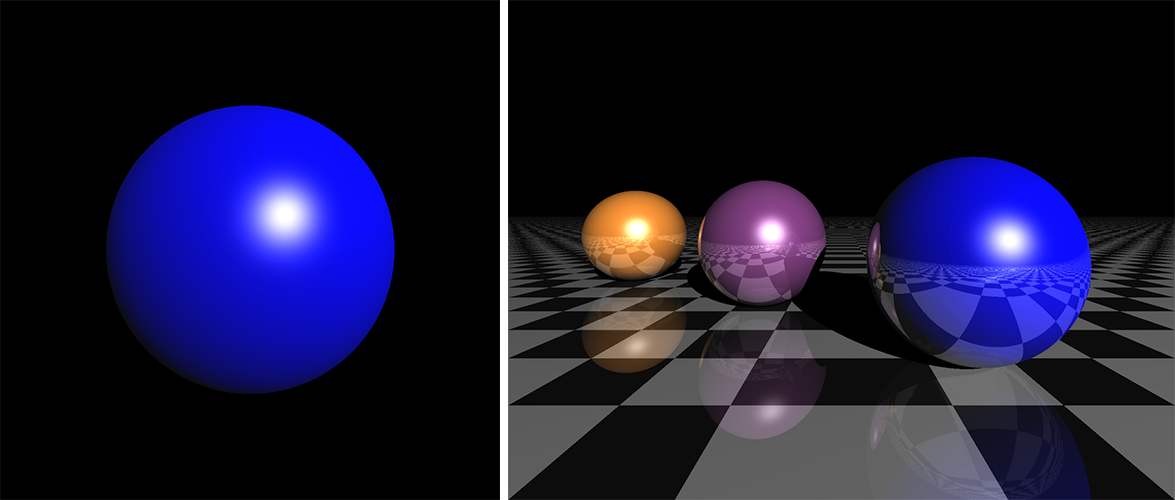

In [9]:
img = run()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img)
ax.set_axis_off()

In [10]:
%timeit run()

2.75 s ± 29.9 ms per loop (mean ± std. dev. of 7 runs,
    1 loop each)


```
import numpy as np
cimport numpy as np
DBL = np.double ctypedef
np.double_t DBL_C
```

```
from libc.math cimport sqrt
cdef normalize(np.ndarray[DBL_C, ndim=1] x):
    cdef double n
    n = sqrt(x[0]*x[0] + x[1]*x[1] + x[2]*x[2])
    x[0] /= n
    x[1] /= n
    x[2] /= n
    return x
```

```
cdef tuple add(tuple x, tuple y):
    return (x[0]+y[0], x[1]+y[1], x[2]+y[2])
```

```
cdef struct Vec3:
    double x, y, z
```

```
cdef Vec3 vec3(double x, double y, double z):
    cdef Vec3 v
    v.x = x
    v.y = y
    v.z = z
    return v
```

```
cdef Vec3 add(Vec3 u, Vec3 v):
    return vec3(u.x + v.x, u.y + v.y, u.z + v.z)
```